# Hyperparameter optimisation

In this section, we cover the topic of `overfitting`. A folk theorem in asset management is that people are so afraid of overfitting that they tend to (massively) underfit. Or at least, that was the case. Today, better fitting models to extract as much information from a dataset has become a crucial skill. 

More precisely, `overfitting` a particular dataset provides a baseline for how well a system can learn (e.g. see the Recipe for Training Neural Nets by Andrej Karpathy). 

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

logging.basicConfig(level=logging.CRITICAL)

from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.estimators import MLPRegressor, MultiLGBMRegressor, RidgeCV
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.plot import bar, line
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean().fillna(0)
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

## Ridge CV

A first strategy is to use estimators that embed some form of cross-validation like `RidgeCV`. K-fold cross validation is described as follows: 

Take a model with parameter $s$ (e.g. the Ridge with tuning parameter `alpha`): 

1. divide the data into $K$ roughly equal parts ($K = 5$ or $K = 10$)

1. for each $k \in \{1, 2,..., K\}$ fit the model with parameter $s$ to the other $K-1$ parts and compute its error $E_k(s)$  in predicting the $k$-th part.

1. the overall cross-validation error is then $CV(s)= \frac{1}{K} \sum_{k=1}^K E_k(s)$. 

1. do this for many values of $s$ and choose the value of s that minimize $CV (s)$

In [2]:
alphas = np.exp(np.arange(np.log(10), np.log(10001), (np.log(10000) - np.log(10)) / 10))

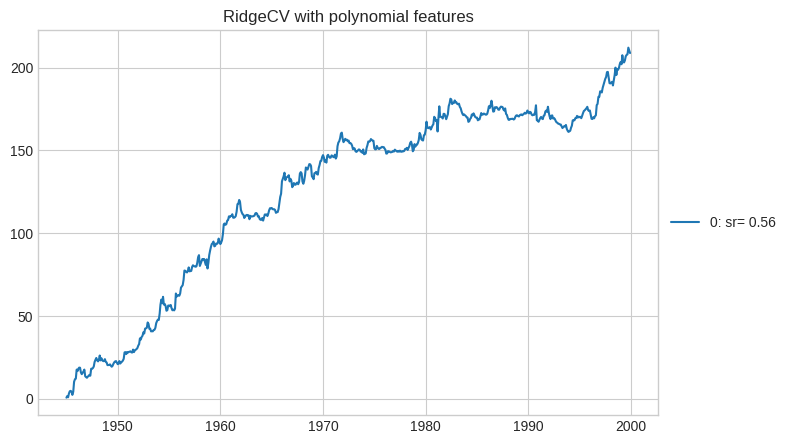

In [3]:
estimator = make_pipeline(
    StandardScaler(with_mean=False),
    PolynomialFeatures(degree=2),
    RidgeCV(alphas=alphas, cv=5),
    MeanVariance(),
)

m = Backtester(estimator).compute_holdings(features, target).compute_pnl(ret)
line(m.pnl_, cumsum=True, title="RidgeCV with polynomial features")

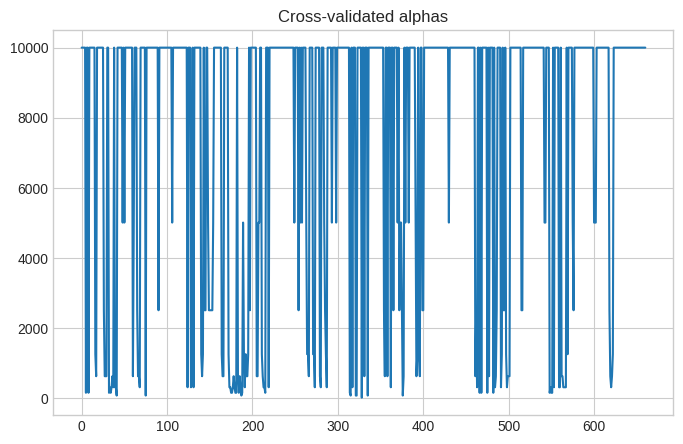

In [4]:
line(
    pd.Series([m[2].alpha_ for m in m.estimators_]),
    title="Cross-validated alphas",
    legend=False,
)

In this example, the fitted alphas over rolling windows are not very stable (probably given the small rolling windows used here).

## Random parameter search for Lightgbm

We first compute a `Lightgbm` benchmark with the fixed baseline parameters used in a previous section. 

Some resources on the parameters of `Lightgbm` can be found in its documentation: 

- https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning-control-parameters

In [5]:
estimator = make_pipeline(
    MultiLGBMRegressor(min_child_samples=5, n_estimators=25), MeanVariance()
)

pnl_lgb = {"fixed_params": Backtester(estimator).train(features, target, ret)}

We now do a search with random parameters drawn from predetermined distributions: 

- the random parameter generators come from the `scipy.stats` module -- in particular `randint`, `uniform` and `loguniform`.
- we use the `scikit-learn` function `ParameterSampler` as wrapper. 

Setup: 

- the objective is to maximize the sharpe ratio over the early period 1945 to 1972 (as the `train` period). 
- the evaluation is the performance of the backtest over the 1972-to-2000 period (as the `test` period). 

In [6]:
from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import ParameterSampler

In [7]:
n_iter = 300
start_date = "1945-01-01"
end_date = "1972-04-01"
param_distributions = {
    "max_depth": randint(3, 10),
    "num_leaves": randint(2, 2**8),
    "n_estimators": randint(5, 50),
    "min_split_gain": uniform(0, 1.0),
    "min_child_samples": randint(1, 5),
    "reg_lambda": loguniform(1e-8, 1.0),
    "reg_alpha": loguniform(1e-8, 1.0),
}

In [8]:
force_recompute = False
cache_dir = Path(os.getcwd()) / "cache"
if not cache_dir.is_dir():
    os.makedirs(cache_dir)

fname = cache_dir / "hpo_lgb.parquet"
if (force_recompute) | (not fname.exists()):
    results_ = {}
    for i, prm in enumerate(
        ParameterSampler(param_distributions=param_distributions, n_iter=n_iter)
    ):
        estimator = make_pipeline(MultiLGBMRegressor(**prm), MeanVariance())
        pnl_ = Backtester(estimator, end_date=end_date).train(features, target, ret)
        prm.update({"sr": pnl_.pipe(sharpe_ratio)})
        results_[i] = pd.Series(prm)
    results = pd.DataFrame.from_dict(results_, orient="index").sort_values("sr")
    results.to_parquet(fname)
else:
    results = pd.read_parquet(fname)

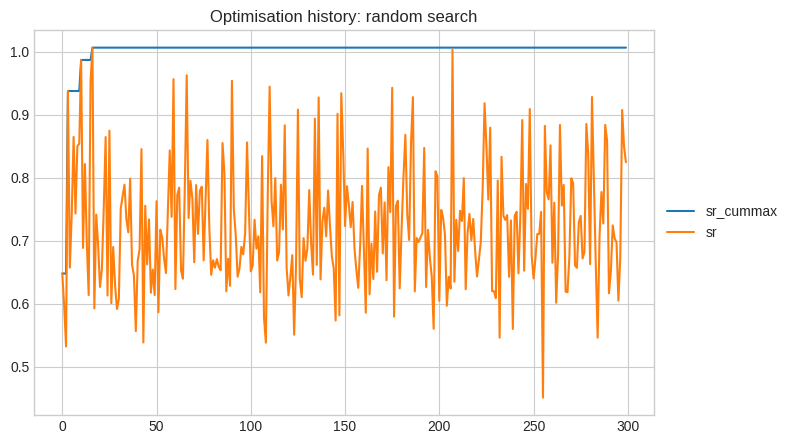

In [9]:
df = results.sort_index()[["sr"]].assign(sr_cummax=lambda x: x.sr.cummax())
line(df, title="Optimisation history: random search")

Using the sharpe ratio statistics presented in a previous section, we can compute a standard error around the maximum sharpe ratio: 

In [10]:
sr_max = results.iloc[-1]["sr"] / np.sqrt(12)
sr_std = np.sqrt(12) * np.sqrt((1 + 0.5 * sr_max**2) / len(ret[start_date:end_date]))
sr_range = results["sr"].pipe(lambda x: x.max() - x.min())
print(
    f"The sharpe ratio standard deviation at the maximum sharpe ratio (of {sr_max * np.sqrt(12):.2f}) is {sr_std:.2f}"
)

print(f"The range of the sharpe ratios in the random search is {sr_range:.2f}")

The sharpe ratio standard deviation at the maximum sharpe ratio (of 1.01) is 0.20
The range of the sharpe ratios in the random search is 0.56


In [11]:
best_params = results.drop("sr", axis=1).iloc[-1].to_dict()
best_params["num_leaves"] = int(best_params["num_leaves"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_samples"] = int(best_params["min_child_samples"])
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params

{'max_depth': 3,
 'min_child_samples': 4,
 'min_split_gain': 0.4620819529118264,
 'n_estimators': 13,
 'num_leaves': 232,
 'reg_alpha': 0.008802935155703386,
 'reg_lambda': 0.14660332145137617}

In [12]:
estimator = make_pipeline(MultiLGBMRegressor(**best_params), MeanVariance())


pnl_lgb["best_params"] = Backtester(estimator).train(features, target, ret)

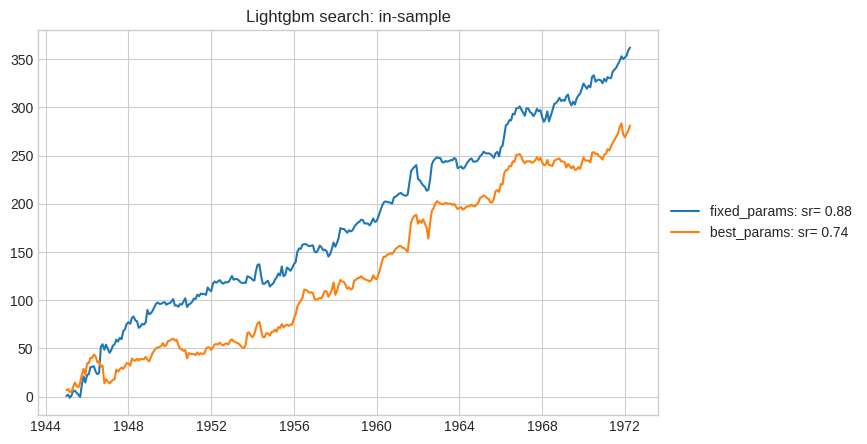

In [13]:
line(
    {k: v.loc[start_date:end_date] for k, v in pnl_lgb.items()},
    cumsum=True,
    title="Lightgbm search: in-sample",
)

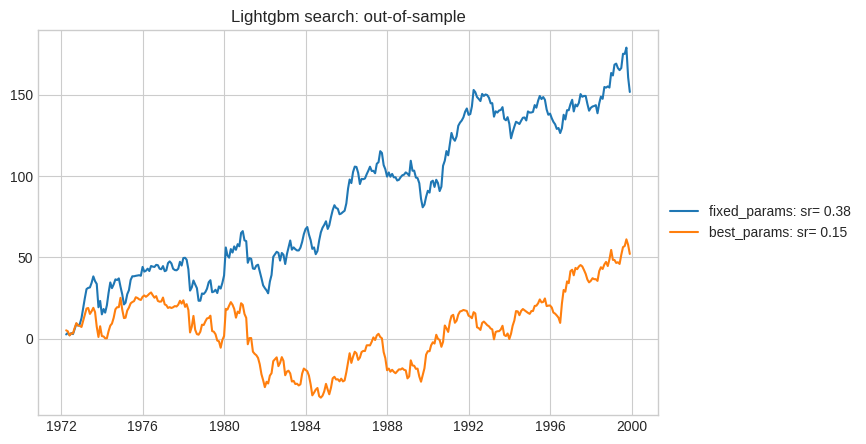

In [14]:
line(
    {k: v.loc[end_date:] for k, v in pnl_lgb.items()},
    cumsum=True,
    title="Lightgbm search: out-of-sample",
)

What are the parameters that are correlated with the sharpe ratio? 

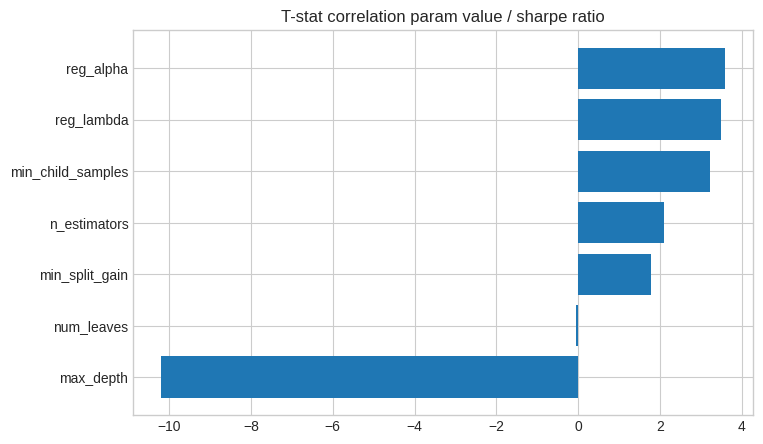

In [15]:
bar(
    results.corr()["sr"].mul(np.sqrt(n_iter)).drop("sr"),
    title="T-stat correlation param value / sharpe ratio",
    horizontal=True,
)

To assess more precisely the impact of parameters on the sharpe ratio, we run a regression. 

In [16]:
from statsmodels import api

m = api.OLS(results["sr"], api.add_constant(results.drop("sr", axis=1))).fit()

In [17]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sr   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     39.11
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.52e-38
Time:                        12:06:55   Log-Likelihood:                 368.57
No. Observations:                 300   AIC:                            -721.1
Df Residuals:                     292   BIC:                            -691.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7920      0.021     37.522      0.000       0.750       0.834
max_depth            -0.0279      0.002    -13.739      0.000      -0.032      -0.024
min_child_samples     0.0155      0.004      4.023      0.000       0.008       0.023
min_split_gain        0.0480      0.015      3.209      0.001       0.019       0.078
n_estimators          0.0009      0.000      2.763      0.006       0.000       0.002
num_leaves         2.155e-05   5.57e-05      0.387      0.699   -8.81e-05       0.000
reg_alpha             0.1476      0.027      5.457      0.000       0.094       0.201
reg_lambda            0.0920      0.022      4.189      0.000       0.049       0.135
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   0.891
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.713
Skew:                          -0.049   Prob(JB):                        0.425
Kurtosis:                       3.357   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""